# Load Data

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM
from keras.utils import to_categorical
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os


In [2]:
data_folder = './EEG-Data'
os.chdir(data_folder)
print(os.getcwd())

c:\Users\tiffh\ECE-C147\Deep-Learning-EEG-BCI-Signal-Processing\EEG-Data


(2115, 22, 1000)


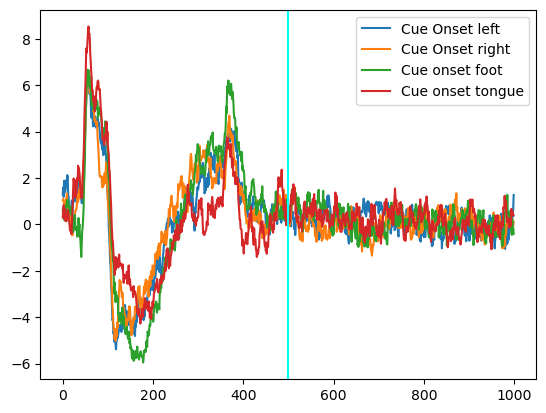

In [3]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [40]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X

## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep = test_data_prep(X_test) 

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
x_valid_prep = test_data_prep(x_valid)
x_train, y_train = train_data_prep(x_train, y_train, 2,2,True)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid_prep.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid_prep.reshape(x_valid_prep.shape[0], x_valid_prep.shape[1], x_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of X after trimming: (250, 22, 800)
Shape of X after maxpooling: (250, 22, 400)
Shape of X after trimming: (1865, 22, 800)
Shape of X after maxpooling: (1865, 22, 400)
Shape of X after averaging+noise and concatenating: (3730, 22, 400)
Shape of X after subsampling and concatenating: (7460, 22, 400)
Shape of Y: (7460,)
Shape of training set: (7460, 22, 400)
Shape of validation set: (250, 22, 400)
Shape of training labels: (7460,)
Shape of validation labels: (250,)
Shape of training labels after categorical conversion: (7460, 4)
Shape of validation labels after categorical conversion: (250, 4)
Shape of test labels after categorical conversion: (443, 4, 4)
Shape of training set after adding width info: (7460, 22, 400, 1)
Shape of validation set after adding width info: (250, 22, 400, 1)
Shape of test set after adding width info: (443, 22, 400, 1)
Shape of training set after dimension reshaping: (74

In [6]:

# ## Preprocessing the dataset

# X_train_valid_prep,y_train_valid_prep = train_data_prep(X_train_valid,y_train_valid,2,2,True)
# X_test_prep = test_data_prep(X_test) 

# ## Random splitting and reshaping the data

# # First generating the training and validation indices using random splitting
# ind_valid = np.random.choice(8460, 1000, replace=False)
# ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# # Creating the training and validation sets using the generated indices
# (x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
# (y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
# print('Shape of training set:',x_train.shape)
# print('Shape of validation set:',x_valid.shape)
# print('Shape of training labels:',y_train.shape)
# print('Shape of validation labels:',y_valid.shape)


# # Converting the labels to categorical variables for multiclass classification
# y_train = to_categorical(y_train, 4)
# y_valid = to_categorical(y_valid, 4)
# y_test = to_categorical(y_test, 4)
# print('Shape of training labels after categorical conversion:',y_train.shape)
# print('Shape of validation labels after categorical conversion:',y_valid.shape)
# print('Shape of test labels after categorical conversion:',y_test.shape)

# # Adding width of the segment to be 1
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
# x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
# x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
# print('Shape of training set after adding width info:',x_train.shape)
# print('Shape of validation set after adding width info:',x_valid.shape)
# print('Shape of test set after adding width info:',x_test.shape)


# # Reshaping the training and validation dataset
# x_train = np.swapaxes(x_train, 1,3)
# x_train = np.swapaxes(x_train, 1,2)
# x_valid = np.swapaxes(x_valid, 1,3)
# x_valid = np.swapaxes(x_valid, 1,2)
# x_test = np.swapaxes(x_test, 1,3)
# x_test = np.swapaxes(x_test, 1,2)
# print('Shape of training set after dimension reshaping:',x_train.shape)
# print('Shape of validation set after dimension reshaping:',x_valid.shape)
# print('Shape of test set after dimension reshaping:',x_test.shape)


# Hybrid Model Architecture

In [43]:
def hybrid_model(units, input_dim):
 # Building the model using sequential class
    hybrid_cnn_lstm_model = Sequential()

    for filter, num_filter in zip([10 for _ in range(4)], [25, 50, 100, 200]):
        hybrid_cnn_lstm_model.add(Conv2D(filters=num_filter, kernel_size=(filter,1), padding='same', activation='elu', input_shape=(400,1,22)))
        hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
        hybrid_cnn_lstm_model.add(BatchNormalization())
        hybrid_cnn_lstm_model.add(Dropout(0.6))


    # FC+LSTM layers
    hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
    hybrid_cnn_lstm_model.add(Dense((input_dim))) # FC layer with 100 units
    hybrid_cnn_lstm_model.add(Reshape((input_dim,1))) # Reshape my output of FC layer so that it's compatible
    hybrid_cnn_lstm_model.add(LSTM(units, dropout=0.4, recurrent_dropout=0.1, input_shape=(input_dim,1), return_sequences=False))


    # Output layer with Softmax activation 
    hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    keras.utils.plot_model(hybrid_cnn_lstm_model, to_file='./Gallery/hybrid_cnn_model_plot.png', show_shapes=True, show_layer_names=True)

    return hybrid_cnn_lstm_model


# # Printing the model summary
# hybrid_cnn_lstm_model.summary()

hybrid_model(10, 40)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Train Hybrid Model

In [7]:
# Model parameters
learning_rate = 1e-2
epochs = 100
# hybrid_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [11]:
from keras.callbacks import ReduceLROnPlateau

units = range(10, 101, 10)
input_dims = range(10, 101, 10)
results = []

for unit in units:
    for dim in input_dims:
        model = hybrid_model(unit, dim)
        # Compiling the model
        model.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                        metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                    patience=5, min_lr=5e-5)
        # Training and validating the model
        model_results = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[reduce_lr],
                    verbose=True)
        
        results.append(model_results)
        
        hybrid_score = model.evaluate(x_test, y_test, verbose=0)
        model_filename = f'../Models/CNN_LSTM_hybrid_{hybrid_score[1]}_{unit}_{dim}.h5'
        model.save(model_filename)



Epoch 1/100
117/117 [==============================] - 13s 70ms/step - loss: 1.3774 - accuracy: 0.2999 - val_loss: 1.3878 - val_accuracy: 0.2720 - lr: 0.0100
Epoch 2/100
117/117 [==============================] - 9s 74ms/step - loss: 1.3152 - accuracy: 0.3643 - val_loss: 1.2750 - val_accuracy: 0.3800 - lr: 0.0100
Epoch 3/100
117/117 [==============================] - 8s 72ms/step - loss: 1.2570 - accuracy: 0.4280 - val_loss: 1.3616 - val_accuracy: 0.3400 - lr: 0.0100
Epoch 4/100
117/117 [==============================] - 9s 80ms/step - loss: 1.2230 - accuracy: 0.4495 - val_loss: 1.2247 - val_accuracy: 0.4160 - lr: 0.0100
Epoch 5/100
117/117 [==============================] - 11s 93ms/step - loss: 1.1990 - accuracy: 0.4588 - val_loss: 1.2108 - val_accuracy: 0.4360 - lr: 0.0100
Epoch 6/100
117/117 [==============================] - 10s 89ms/step - loss: 1.1745 - accuracy: 0.4752 - val_loss: 1.2373 - val_accuracy: 0.3960 - lr: 0.0100
Epoch 7/100
117/117 [==============================] - 

c:\Users\tiffh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
117/117 [==============================] - 16s 89ms/step - loss: 1.3550 - accuracy: 0.3176 - val_loss: 1.3849 - val_accuracy: 0.2840 - lr: 0.0100
Epoch 2/100
117/117 [==============================] - 10s 86ms/step - loss: 1.2771 - accuracy: 0.4000 - val_loss: 1.3722 - val_accuracy: 0.3200 - lr: 0.0100
Epoch 3/100
117/117 [==============================] - 10s 86ms/step - loss: 1.2316 - accuracy: 0.4307 - val_loss: 1.2277 - val_accuracy: 0.4200 - lr: 0.0100
Epoch 4/100
117/117 [==============================] - 11s 90ms/step - loss: 1.2046 - accuracy: 0.4560 - val_loss: 1.2268 - val_accuracy: 0.4400 - lr: 0.0100
Epoch 5/100
117/117 [==============================] - 10s 88ms/step - loss: 1.1821 - accuracy: 0.4696 - val_loss: 1.1812 - val_accuracy: 0.4480 - lr: 0.0100
Epoch 6/100
117/117 [==============================] - 9s 78ms/step - loss: 1.1638 - accuracy: 0.4839 - val_loss: 1.1504 - val_accuracy: 0.4680 - lr: 0.0100
Epoch 7/100
117/117 [==============================] 

KeyboardInterrupt: 

In [13]:
from keras.callbacks import ReduceLROnPlateau

units = range(40, 101, 20)
input_dims = range(10, 101, 20)

new_results = []

for unit in units:
    for dim in input_dims:
        model = hybrid_model(unit, dim)
        # Compiling the model
        model.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                        metrics=['accuracy'])

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                                    patience=5, min_lr=5e-5)
        # Training and validating the model
        model_results = model.fit(x_train,
                    y_train,
                    batch_size=64,
                    epochs=epochs,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[reduce_lr],
                    verbose=True)
        
        new_results.append(model_results)
        
        hybrid_score = model.evaluate(x_test, y_test, verbose=0)
        model_filename = f'../Models/CNN_LSTM_hybrid_{hybrid_score[1]}_{unit}_{dim}.h5'
        model.save(model_filename)



Epoch 1/100
117/117 [==============================] - 13s 77ms/step - loss: 1.3624 - accuracy: 0.3080 - val_loss: 1.4611 - val_accuracy: 0.2960 - lr: 0.0100
Epoch 2/100
117/117 [==============================] - 9s 74ms/step - loss: 1.2765 - accuracy: 0.4000 - val_loss: 1.3021 - val_accuracy: 0.3680 - lr: 0.0100
Epoch 3/100
117/117 [==============================] - 8s 64ms/step - loss: 1.2368 - accuracy: 0.4304 - val_loss: 1.2846 - val_accuracy: 0.4000 - lr: 0.0100
Epoch 4/100
117/117 [==============================] - 7s 64ms/step - loss: 1.2050 - accuracy: 0.4591 - val_loss: 1.1880 - val_accuracy: 0.4560 - lr: 0.0100
Epoch 5/100
117/117 [==============================] - 7s 60ms/step - loss: 1.1621 - accuracy: 0.4819 - val_loss: 1.1696 - val_accuracy: 0.4640 - lr: 0.0100
Epoch 6/100
117/117 [==============================] - 7s 59ms/step - loss: 1.1575 - accuracy: 0.4806 - val_loss: 1.1670 - val_accuracy: 0.4440 - lr: 0.0100
Epoch 7/100
117/117 [==============================] - 7s

c:\Users\tiffh\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/100
117/117 [==============================] - 12s 74ms/step - loss: 1.3578 - accuracy: 0.3276 - val_loss: 1.2590 - val_accuracy: 0.3920 - lr: 0.0100
Epoch 2/100
117/117 [==============================] - 8s 70ms/step - loss: 1.2650 - accuracy: 0.4202 - val_loss: 1.3662 - val_accuracy: 0.3280 - lr: 0.0100
Epoch 3/100
117/117 [==============================] - 8s 71ms/step - loss: 1.2201 - accuracy: 0.4425 - val_loss: 1.2953 - val_accuracy: 0.3880 - lr: 0.0100
Epoch 4/100
117/117 [==============================] - 8s 72ms/step - loss: 1.1975 - accuracy: 0.4531 - val_loss: 1.2441 - val_accuracy: 0.4080 - lr: 0.0100
Epoch 5/100
117/117 [==============================] - 8s 71ms/step - loss: 1.1862 - accuracy: 0.4617 - val_loss: 1.3489 - val_accuracy: 0.3680 - lr: 0.0100
Epoch 6/100
117/117 [==============================] - 8s 71ms/step - loss: 1.1720 - accuracy: 0.4690 - val_loss: 1.1644 - val_accuracy: 0.4320 - lr: 0.0100
Epoch 7/100
117/117 [==============================] - 8s

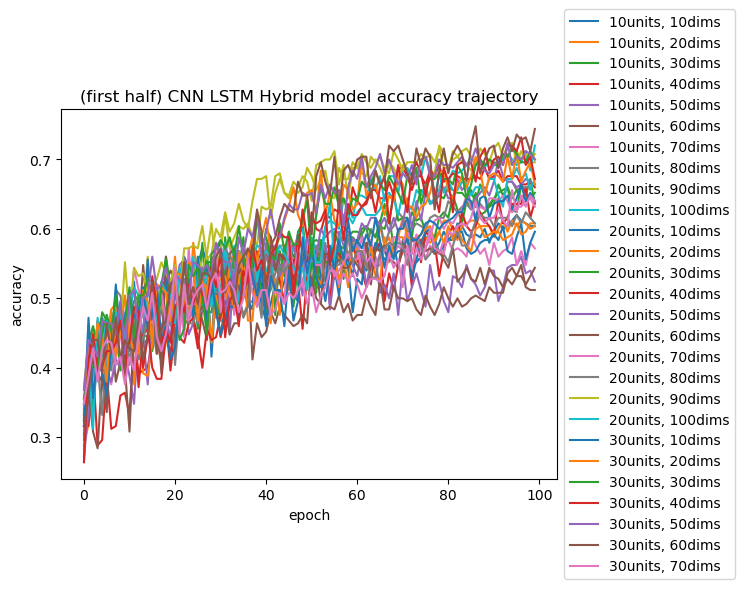

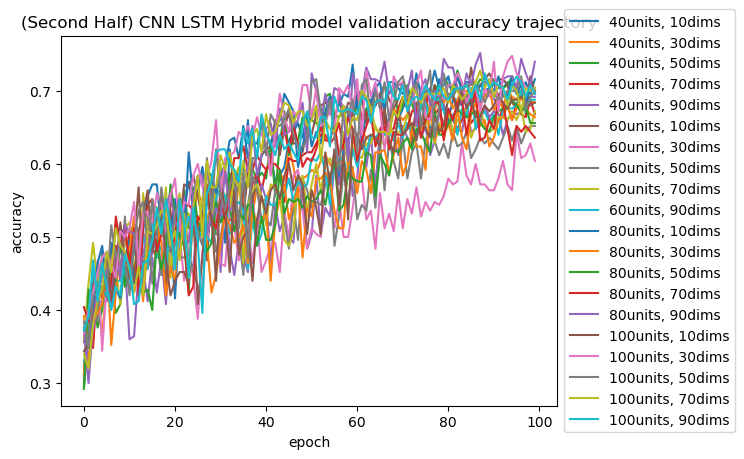

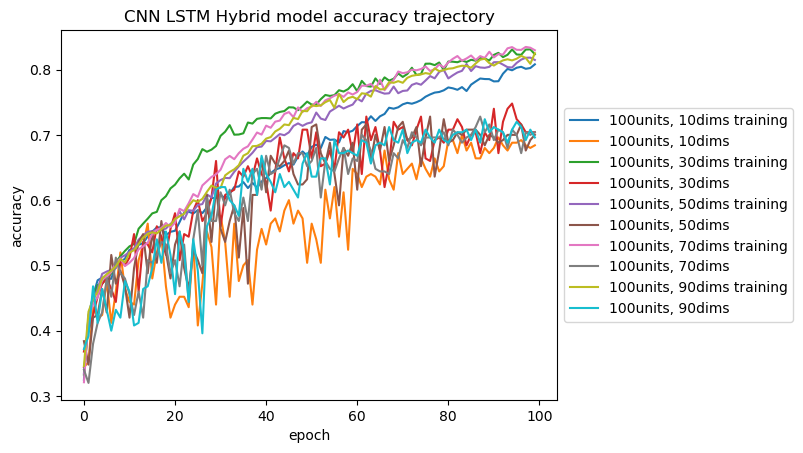

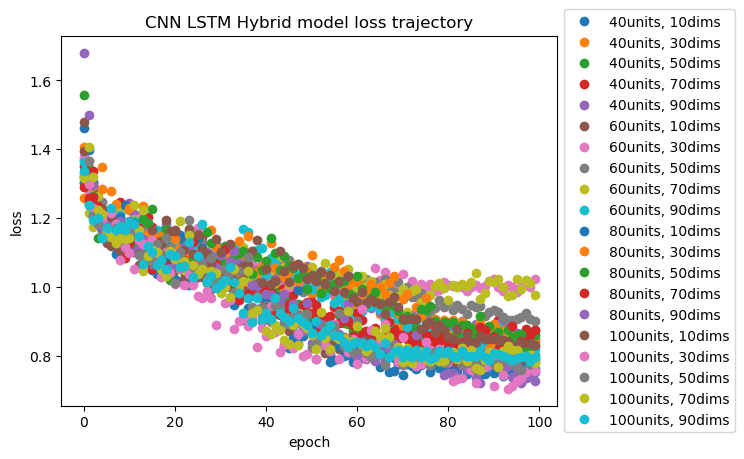

In [39]:
import matplotlib.pyplot as plt
import matplotlib.axes as ax

# colormap = plt.cm.nipy_spectral
# colors = colormap(np.linspace(0, 1, len(new_results)))
# ax.Axes.set_prop_cycle('color', colors)
labels0 = [str(i) + "units, " + str(j) + "dims" for i in range(10, 101, 10) for j in range(10, 101, 10)]
labels = [str(i) + "units, " + str(j) + "dims" for i in range(40, 101, 20) for j in range(10, 101, 20)]

for result, i in zip(results, range(len(results))):
    # plt.plot(result.history['accuracy'])
    # if (i == 25 or i == 5):
    plt.plot(result.history['val_accuracy'], label=labels0[i])
    plt.title('(first half) CNN LSTM Hybrid model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting accuracy trajectory
for result, i in zip(new_results, range(len(new_results))):
    # plt.plot(result.history['accuracy'])
    plt.plot(result.history['val_accuracy'], label=labels[i])
    plt.title('(Second Half) CNN LSTM Hybrid model validation accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

for result, i in zip(new_results, range(len(new_results))):
    # plt.plot(result.history['accuracy'])
    if i > 14:
        plt.plot(result.history['accuracy'], label=labels[i]+" training")
        plt.plot(result.history['val_accuracy'], label=labels[i])
        plt.title('CNN LSTM Hybrid model accuracy trajectory')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Plotting loss trajectory
for result, i in zip(new_results, range(len(new_results))):
    # plt.plot(result.history['loss'],'o')
    plt.plot(result.history['val_loss'],'o', label=labels[i])
    plt.title('CNN LSTM Hybrid model loss trajectory')
    plt.ylabel('loss')
    plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

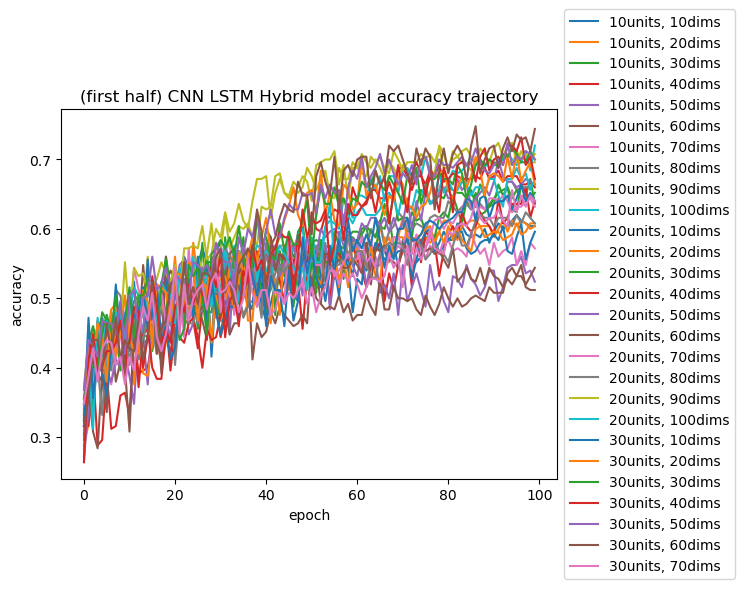

In [50]:
import pickle
with open('./result0_hybrid', 'wb') as fp:
    pickle.dump(results, fp)

with open('./result1_hybrid', 'wb') as fp:
    pickle.dump(new_results, fp)

with open('./result0_hybrid', 'rb') as fp:
    test_result0 = pickle.load(fp)

with open('./result1_hybrid', 'rb') as fp:
    test_result1 = pickle.load(fp)

labels0 = [str(i) + "units, " + str(j) + "dims" for i in range(10, 101, 10) for j in range(10, 101, 10)]
# labels = [str(i) + "units, " + str(j) + "dims" for i in range(40, 101, 20) for j in range(10, 101, 20)]

for result, i in zip(results, range(len(test_result0))):
    # plt.plot(result.history['accuracy'])
    # if (i == 25 or i == 5):
    plt.plot(result.history['val_accuracy'], label=labels0[i])
    plt.title('(first half) CNN LSTM Hybrid model accuracy trajectory')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [52]:
os.getcwd()

'c:\\Users\\tiffh\\ECE-C147\\Deep-Learning-EEG-BCI-Signal-Processing\\EEG-Data'

In [34]:
## Testing the basic RNN model

rnn_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN LSTM model:',rnn_score[1])

Test accuracy of the hybrid CNN LSTM model: 0.7133182883262634
